# Using PyDAP for simple remote data access
This notebook contains a simple example of how to use PyDAP to pull
data from remote DAP servers into your Python programs memory space
so that the data may be analyized and displayed.

We show how to use simple HTTP requests to look at a dataset's metadata
and how to use the PyDAP package to read data into numpy arrays and plot
(or do other things) with those data. PyDAP provides lazy evaluation, so
data are read only when needed.

This tutorial utilizes the NASA Global High Resolution Sea Surface Temperature from the GOES-16 satellite. You may wish to review the summary on our [Tutorial Datasets page](https://opendap.github.io/documentation/tutorials/TutorialDatasets.html#_nasa_global_high_resolution_sea_surface_temperature_goes_16_satellite) before continuing.

You can run this tutorial in your browser by [launching it in binder](https://mybinder.org/v2/gh/OPENDAP/notebooks/master?labpath=tutorials%2Fpydap_dap2_basic.ipynb)


Copyright (C) 2023 OPeNDAP, Inc.
This Jupyter Notebook is made available under the [Creative Commons Attribution license 4.0](https://creativecommons.org/licenses/by/4.0/).

In [8]:
# The requests package provides a high-level interface to HTTP/S
import requests

# Install using 'conda install requests'


# Use the netCDF4 library to read data
# from netCDF4 import Dataset as NetCDFFile
# import xarray as xr
from pydap.client import open_url
from pydap.cas.urs import setup_session

# Install using 'conda install -c conda-forge pydap'

# Use matplotlib and numpy for plotting and local data manipulation
import matplotlib.pyplot as plt
import numpy as np

# These are part of the conda base

# Using basemap with Anaconda/Jupyter and Python 3, I had to set this env var.
# I might have been able to do this in the shell that started the notebook server,
# but that would obfuscate a detail that seems to generate considerable traffic on
# Stackoverflow... jhrg 4/22/20
# Maybe if I had used a conda environment other than 'base' this would not have been an issue
# jhrg 4/23/20
import os
os.environ['PROJ_LIB'] = '/Users/ndp/opt/anaconda3/pkgs/proj4-5.0.1-h1de35cc_0/share/proj'

from mpl_toolkits.basemap import Basemap

# Install using 'conda install basemap'
# To plot hig resolution maps, use 'conda install basemap-data-highres'
# NB: We will need to shift to Cartopy soon...

from IPython.display import Code

import sys
# Allow us to print the big things...
# np.set_printoptions(threshold=sys.maxsize)


## dataset_url

The dataset_url is the DAP2/DAP4 service endpoint for the dataset.

This first URL points to a copy of the example dataset hosted at test.opendap.org

In [9]:
dataset_url="http://test.opendap.org/opendap/tutorials/20220812010000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20220812_010000-v02.0-fv01.0.nc"

This second URL points to the DAP sevice endpoint for the test granule at the original data publishers site, in this case NASA. That means that to utilize this URL you will need to: 
* [Configure your client (in this cae PyDAP) to authenticate with the appropriate Earthdata Login (EDL) service](https://opendap.github.io/documentation/tutorials/ClientAuthentication.html#_pydap)
* Uncomment the next line that points to NASA's DAP service endpoint for the example dataset.

In [10]:
# datset_url="https://opendap.earthdata.nasa.gov/collections/C2036877806-POCLOUD/granules/20220812010000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20220812_010000-v02.0-fv01.0"


## Look at the metadata
Lets look at the dataset's contents, first by looking at the variables in the dataset. We can do this by appending the extension _dds_ to the dataset's URL. The _Data Access Protocol_ denotes the different kinds of responses from a dataset using extensions. The most important ones are:
- **dds** Get information about the variables
- **das** Get semantic (i.e., attributes) about the dataset and its variables
- **dods** Get binary data (for individual or groups of variables)
- **ascii** Get data as ASCII, really useful for looking at small parts or a dataset

In [11]:
http_response = requests.get(dataset_url + '.' + 'dds')

In [12]:
print(http_response.url)

http://test.opendap.org/opendap/tutorials/20220812010000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20220812_010000-v02.0-fv01.0.nc.dds


In [13]:
Code(http_response.text, language='C')

Dataset {
    Int32 time[time = 1];
    Float32 lat[lat = 2400];
    Float32 lon[lon = 2400];
    Grid {
      Array:
        Int16 sea_surface_temperature[time = 1][lat = 2400][lon = 2400];
      Maps:
        Int32 time[time = 1];
        Float32 lat[lat = 2400];
        Float32 lon[lon = 2400];
    } sea_surface_temperature;
    Grid {
      Array:
        Int32 sst_dtime[time = 1][lat = 2400][lon = 2400];
      Maps:
        Int32 time[time = 1];
        Float32 lat[lat = 2400];
        Float32 lon[lon = 2400];
    } sst_dtime;
    Grid {
      Array:
        Int16 sses_bias[time = 1][lat = 2400][lon = 2400];
      Maps:
        Int32 time[time = 1];
        Float32 lat[lat = 2400];
        Float32 lon[lon = 2400];
    } sses_bias;
    Grid {
      Array:
        Int16 sses_standard_deviation[time = 1][lat = 2400][lon = 2400];
      Maps:
        Int32 time[time = 1];
        Float32 lat[lat = 2400];
        Float32 lon[lon = 2400];
    } sses_standard_deviation;
    Grid {
      Array:
        Int16 dt_analysis[time = 1][lat = 2400][lon = 2400];
      Maps:
        Int32 time[time = 1];
        Float32 lat[lat = 2400];
        Float32 lon[lon = 2400];
    } dt_analysis;
    Grid {
      Array:
        Int16 wind_speed[time = 1][lat = 2400][lon = 2400];
      Maps:
        Int32 time[time = 1];
        Float32 lat[lat = 2400];
        Float32 lon[lon = 2400];
    } wind_speed;
    Grid {
      Array:
        Int16 sea_ice_fraction[time = 1][lat = 2400][lon = 2400];
      Maps:
        Int32 time[time = 1];
        Float32 lat[lat = 2400];
        Float32 lon[lon = 2400];
    } sea_ice_fraction;
    Grid {
      Array:
        Int16 aerosol_dynamic_indicator[time = 1][lat = 2400][lon = 2400];
      Maps:
        Int32 time[time = 1];
        Float32 lat[lat = 2400];
        Float32 lon[lon = 2400];
    } aerosol_dynamic_indicator;
    Grid {
      Array:
        Int16 adi_dtime_from_sst[time = 1][lat = 2400][lon = 2400];
      Maps:
        Int32 time[time = 1];
        Float32 lat[lat = 2400];
        Float32 lon[lon = 2400];
    } adi_dtime_from_sst;
    Grid {
      Array:
        Int16 sources_of_adi[time = 1][lat = 2400][lon = 2400];
      Maps:
        Int32 time[time = 1];
        Float32 lat[lat = 2400];
        Float32 lon[lon = 2400];
    } sources_of_adi;
    Grid {
      Array:
        Int32 l2p_flags[time = 1][lat = 2400][lon = 2400];
      Maps:
        Int32 time[time = 1];
        Float32 lat[lat = 2400];
        Float32 lon[lon = 2400];
    } l2p_flags;
    Grid {
      Array:
        Int16 quality_level[time = 1][lat = 2400][lon = 2400];
      Maps:
        Int32 time[time = 1];
        Float32 lat[lat = 2400];
        Float32 lon[lon = 2400];
    } quality_level;
    Grid {
      Array:
        Int16 satellite_zenith_angle[time = 1][lat = 2400][lon = 2400];
      Maps:
        Int32 time[time = 1];
        Float32 lat[lat = 2400];
        Float32 lon[lon = 2400];
    } satellite_zenith_angle;
    Grid {
      Array:
        Int16 solar_zenith_angle[time = 1][lat = 2400][lon = 2400];
      Maps:
        Int32 time[time = 1];
        Float32 lat[lat = 2400];
        Float32 lon[lon = 2400];
    } solar_zenith_angle;
    Grid {
      Array:
        Int16 or_latitude[time = 1][lat = 2400][lon = 2400];
      Maps:
        Int32 time[time = 1];
        Float32 lat[lat = 2400];
        Float32 lon[lon = 2400];
    } or_latitude;
    Grid {
      Array:
        Int16 or_longitude[time = 1][lat = 2400][lon = 2400];
      Maps:
        Int32 time[time = 1];
        Float32 lat[lat = 2400];
        Float32 lon[lon = 2400];
    } or_longitude;
} 20220812010000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20220812_010000-v02.0-fv01.0.nc;

From this we can see these data consist of four regularly gridded variables. 

Lets look at the dataset's attribute information. From this we can see the values used to denote 'missing' or filled values, units, etc.

In [14]:
http_response = requests.get(dataset_url + '.' + 'das')

In [15]:
Code(http_response.text, language='C')

Attributes {
    time {
        String long_name "reference time of sst file";
        String standard_name "time";
        String axis "T";
        String units "seconds since 1981-01-01 00:00:00";
    }
    lat {
        String long_name "latitude";
        String standard_name "latitude";
        String axis "Y";
        String units "degrees_north";
        Float32 valid_min -90.0000000;
        Float32 valid_max 90.0000000;
        String comment "geographical coordinates, WGS84 projection";
    }
    lon {
        String long_name "longitude";
        String standard_name "longitude";
        String axis "X";
        String units "degrees_east";
        Float32 valid_min -180.000000;
        Float32 valid_max 180.000000;
        String comment "geographical coordinates, WGS84 projection";
    }
    sea_surface_temperature {
        Int16 _FillValue -32768;
        String long_name "sea surface subskin temperature";
        String standard_name "sea_surface_subskin_temperature";
        String units "kelvin";
        Float64 add_offset 273.1500000000000;
        Float64 scale_factor 0.01000000000000000;
        Int16 valid_min -300;
        Int16 valid_max 4500;
        String depth "1 millimeter";
        String source "GOES_Imager";
        String comment "Temperature of the subskin of the ocean";
    }
    sst_dtime {
        Int32 _FillValue -2147483648;
        String long_name "time difference from reference time";
        String units "seconds";
        Float64 add_offset 0.000000000000000;
        Float64 scale_factor 1.000000000000000;
        Int32 valid_min -2147483647;
        Int32 valid_max 2147483647;
        String comment "time plus sst_dtime gives seconds after 00:00:00 UTC January 1, 1981";
    }
    sses_bias {
        Int16 _FillValue -128;
        String long_name "SSES bias estimate";
        String units "kelvin";
        Float64 add_offset 0.000000000000000;
        Float64 scale_factor 0.01000000000000000;
        Int16 valid_min -127;
        Int16 valid_max 127;
        String comment "Bias estimate derived using the techniques described at http://www.ghrsst.org/SSES-Description-of-schemes.html";
    }
    sses_standard_deviation {
        Int16 _FillValue -128;
        String long_name "SSES standard deviation";
        String units "kelvin";
        Float64 add_offset 1.000000000000000;
        Float64 scale_factor 0.01000000000000000;
        Int16 valid_min -127;
        Int16 valid_max 127;
        String comment "Standard deviation estimate derived using the techniques described at http://www.ghrsst.org/SSES-Description-of-schemes.html";
    }
    dt_analysis {
        Int16 _FillValue -128;
        String long_name "deviation from SST analysis or reference climatology";
        String units "kelvin";
        Float64 add_offset 0.000000000000000;
        Float64 scale_factor 0.1000000000000000;
        Int16 valid_min -127;
        Int16 valid_max 127;
        String reference "OSTIA";
        String comment "The difference between this SST and the previous day's SST analysis";
    }
    wind_speed {
        Int16 _FillValue -128;
        String long_name "10m wind speed";
        String standard_name "wind_speed";
        String units "m s-1";
        String height "10 m";
        Float64 add_offset 0.000000000000000;
        Float64 scale_factor 1.000000000000000;
        Int16 valid_min 0;
        Int16 valid_max 127;
        Float64 time_offset 0.000000000000000;
        String source "WSP-ECMWF-Forecast";
        String comment "These wind speeds were created by the ECMWF and represent winds at 10 metres above the sea surface. ";
    }
    sea_ice_fraction {
        Int16 _FillValue -128;
        String long_name "sea ice fraction";
        String standard_name "sea_ice_area_fraction";
        String units " ";
        Float64 add_offset 0.000000000000000;
        Float64 scale_factor 0.01000000000000000;
        Int16 valid_min 0;
        Int16 valid_max 100;
        Float64 time_of

## Using PyDAP to read values

In [16]:
pydap_ds = open_url(dataset_url)

In [17]:
print(pydap_ds)

<DatasetType with children 'time', 'lat', 'lon', 'sea_surface_temperature', 'sst_dtime', 'sses_bias', 'sses_standard_deviation', 'dt_analysis', 'wind_speed', 'sea_ice_fraction', 'aerosol_dynamic_indicator', 'adi_dtime_from_sst', 'sources_of_adi', 'l2p_flags', 'quality_level', 'satellite_zenith_angle', 'solar_zenith_angle', 'or_latitude', 'or_longitude'>


In [18]:
print("Domain Coordinates")
print("time", pydap_ds.time.shape)
print("lat", pydap_ds.lat.shape)
print("lon", pydap_ds.lon.shape,"\n")

print("Range Variables")
print("sea_surface_temperature", pydap_ds.sea_surface_temperature.shape)
print("wind_speed", pydap_ds.wind_speed.shape)


Domain Coordinates
time (1,)
lat (2400,)
lon (2400,) 

Range Variables
sea_surface_temperature (1, 2400, 2400)
wind_speed (1, 2400, 2400)


### PyDAP only reads the data when  needed
The above call, just like the **open_url()** call, does not get data. The *access* to values in the cells below trigger the data transfers.

This assignment triggers a data read. Note that the grid 'SST' is being subset here.
Only the ''sliced' data are read. This is in addition to the subsetting performed by the grid() function. PyDAP enables constraints to be built up in this way, until an action like assignment triggers a read operation. This feature is often known as _lazy evaluation_ because the action can be _defined_ in stages and is not run until the values are needed.

In [19]:
# Get and inspect the domain coordinate variable "time"
time = pydap_ds.time.data[:]
print("time",time.shape,time,"\n")

time (1,) [1313110800] 



In [20]:
# Get and inspect the domain coordinate variable "lat"
lat = pydap_ds.lat.data[:]
print("lat",lat.shape,": ",lat,"\n")

lat (2400,) :  [-59.975 -59.925 -59.875 ...  59.875  59.925  59.975] 



In [21]:
# Get and inspect the domain coordinate variable "lon"
lon = pydap_ds.lon.data[:]
print("lon", lon.shape, "\n")
print( lon, "\n")

lon (2400,) 

[-134.975 -134.925 -134.875 ...  -15.125  -15.075  -15.025] 



In [22]:
# Get and inspect the range coordinate variable "sea_surface_temperature"
sst=pydap_ds.sea_surface_temperature.array.data[:]
print(sst)

[[[-32768 -32768 -32768 ... -32768 -32768 -32768]
  [-32768 -32768 -32768 ... -32768 -32768 -32768]
  [-32768 -32768 -32768 ... -32768 -32768 -32768]
  ...
  [-32768 -32768 -32768 ... -32768 -32768 -32768]
  [-32768 -32768 -32768 ...   1513   1513   1513]
  [-32768 -32768 -32768 ...   1345   1345 -32768]]]


In [23]:
#
# Here we drop the time dimension
# (which is now has size 1) using numpy.squeeze()

print("Before Squeeze, sst.shape",sst.shape)
sst = np.squeeze(sst)
print("After Squeeze, sst.shape",sst.shape)

#
# Convert to Float32 so that we can meaningfull fill values for BaseMap
sst = sst[:].astype(np.float32)

# Create FillValues
sst[sst < -32000] = np.nan



Before Squeeze, sst.shape (1, 2400, 2400)
After Squeeze, sst.shape (2400, 2400)


X (2400, 2400)
Y (2400, 2400)
sst (2400, 2400)


Text(0.5, 1.0, 'Sea Surface Temperature')

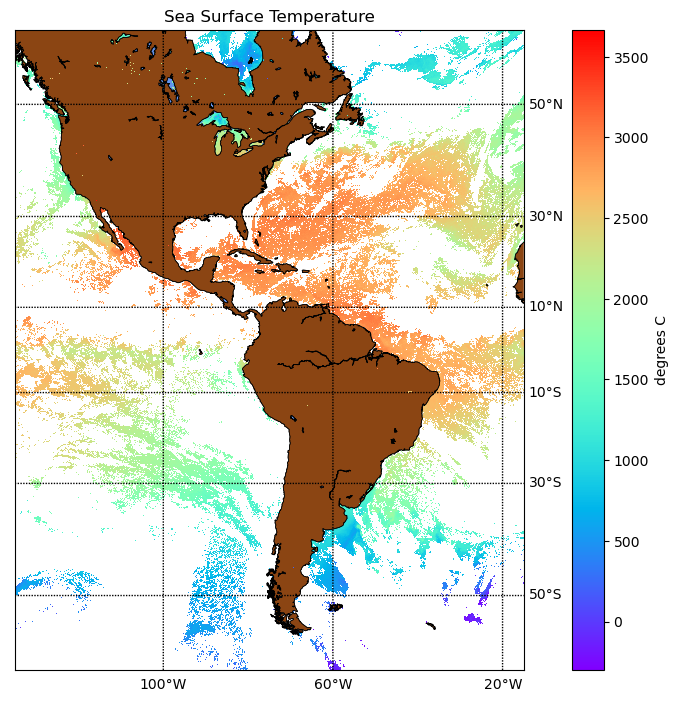

In [24]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

# BaseMap
# The resolution can be l (low), i (intermediate), h (high), f (full)
# But you have to install/configure everything but low
#
# These bounds were chosen based on the bounds of the data. The bounds
# are documented on the TuorialsDatasets page: 
# https://opendap.github.io/documentation/tutorials/TutorialDatasets.html
#
m = Basemap(
    llcrnrlon=-135.,
    llcrnrlat=-60.,
    urcrnrlon=-15.,
    urcrnrlat=60.,
    resolution='l',
    projection='merc')

m.fillcontinents(color='saddlebrown',lake_color='cornflowerblue')

# draw lat and lon line (parallels and meridians).
# and set the axis labels (labels = [left,right,top,bottom])
parallels = np.arange(-70., 80., 20.)
m.drawparallels(parallels, labels=[False,True,False,False])
meridians = np.arange(-180., 180., 40.)
m.drawmeridians(meridians, labels=[False,False,False,True])

# Use meshgrid(lon, lat) to build matrices for the lon, lat values
# and then convert them to map projection coordinates for the Basemap
# object 'm.'

X, Y = m(*np.meshgrid(lon, lat))

print("X",X.shape)
print("Y",Y.shape)
print("sst",sst.shape)

# Plot using the rainbox color map
colors_ = m.pcolormesh(X, Y, sst, cmap=plt.get_cmap('rainbow'))

m.drawcoastlines(linewidth=0.5)

cb = plt.colorbar(colors_)
cb.set_label("degrees C")
m.drawcoastlines(linewidth=0.5)

ax.set_title('Sea Surface Temperature')